In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

con = sqlite3.connect("csgo.db")

csgo_df = pd.read_sql_query("SELECT * from round, game WHERE round.game_id = game.id", con, parse_dates=["time"])
players_df = pd.read_sql_query("SELECT * from players", con)
csgo_df['time'] = pd.to_datetime(csgo_df['time'], utc=True)

In [54]:
csgo_df['survivingCount'] =  csgo_df.survivingPlayers.apply(lambda x: len(x[1:-1].split(',')) if x != 'null' else 0)
csgo_df['longestKillWaitS'] = csgo_df['longestKillWait']/csgo_df['tickrate']

In [55]:
yearly_average = csgo_df.resample("Y", on="time")
yearly_average.mean().dropna()

/tmp/ipykernel_31305/109468099.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_average.mean().dropna()


,round_id,game_id,duration,losingSide,startTick,endTick,endOfficialTick,losingTeamLeftoverMoney,equipmentSavedValue,longestKillWait,lastKillToEnd,round_no,heDamage,id,tickrate,survivingCount,longestKillWaitS
time,,,,,,,,,,,,,,,,,
2014-12-31 00:00:00+00:00,1191.500000,47.668766,76.928631,2.405122,183612.505038,193045.977330,195460.715365,20242.359362,712.132662,2649.380772,462.788833,12.620067,0.000000,47.668766,128.0,0.172544,20.698287
2015-12-31 00:00:00+00:00,13193.117232,494.330508,75.125706,2.466808,184043.480932,193123.972458,195262.085452,14343.326271,1012.853107,2517.884887,569.380650,13.077684,30.726695,494.330508,128.0,0.227401,19.670976
2016-12-31 00:00:00+00:00,7492.030459,281.972844,81.994862,2.477798,213775.664954,223782.119266,226515.080000,19673.155963,971.688073,2806.564037,644.582385,13.342018,26.135046,281.972844,128.0,0.256881,21.926282
2017-12-31 00:00:00+00:00,12738.000000,478.045710,85.543705,2.451484,220782.280674,230951.522855,235926.413793,19603.007217,1255.332799,2949.076985,677.482759,13.319166,21.174018,478.045710,128.0,0.325581,23.039664
2019-12-31 00:00:00+00:00,8334.500000,313.853107,77.003390,2.066667,233057.880226,208867.985311,246652.297740,19986.638418,2549.039548,3337.181356,977.367232,13.256497,25.550282,313.853107,128.0,0.593220,26.071729
2021-12-31 00:00:00+00:00,10131.000000,379.487658,90.317060,2.419089,217485.490400,228516.596270,230317.986835,20816.758091,1997.202414,3408.556775,1081.537575,13.244103,33.112452,379.487658,128.0,0.443774,26.629350
2022-12-31 00:00:00+00:00,3856.500000,146.589552,89.905360,2.445726,232251.232022,243162.265604,244786.142469,20888.839891,2012.042062,3245.373474,1134.177069,13.677748,32.427748,146.589552,128.0,0.446065,25.354480


In [56]:
monthly_average = csgo_df.resample("M", on="time")
monthly_average.mean().dropna()

/tmp/ipykernel_31305/2198300793.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_average.mean().dropna()


,round_id,game_id,duration,losingSide,startTick,endTick,endOfficialTick,losingTeamLeftoverMoney,equipmentSavedValue,longestKillWait,lastKillToEnd,round_no,heDamage,id,tickrate,survivingCount,longestKillWaitS
time,,,,,,,,,,,,,,,,,
2014-03-31 00:00:00+00:00,1363.000000,54.246871,76.517634,2.455063,183883.199090,193149.213879,195122.092150,20454.550626,790.614334,2642.104664,517.871445,12.588168,0.000000,54.246871,128.0,0.188851,20.641443
2014-08-31 00:00:00+00:00,2092.500000,82.734483,81.324138,2.412069,198108.851724,208184.668966,210342.818966,20252.586207,773.189655,2756.577586,453.074138,12.874138,0.000000,82.734483,128.0,0.181034,21.535762
2014-11-30 00:00:00+00:00,462.000000,19.369447,74.557963,2.353196,174245.418202,183434.724810,186431.495125,20033.856988,599.024919,2588.949079,416.436620,12.490791,0.000000,19.369447,128.0,0.151679,20.226165
2015-08-31 00:00:00+00:00,13836.500000,518.251579,75.109474,2.466316,185157.882105,194123.612632,196522.395789,11787.315789,1034.631579,2498.976842,578.362105,13.090526,31.738947,518.251579,128.0,0.238947,19.523257
2015-10-31 00:00:00+00:00,11686.000000,437.986667,79.200000,2.466667,164091.333333,173814.266667,175257.200000,19048.666667,1098.000000,2415.306667,753.173333,12.013333,34.413333,437.986667,128.0,0.240000,18.869583
2015-11-30 00:00:00+00:00,11919.000000,447.017903,74.383632,2.468031,185162.994885,194399.086957,196037.204604,19651.023018,943.606138,2583.501279,512.304348,13.250639,27.560102,447.017903,128.0,0.196931,20.183604
2016-03-31 00:00:00+00:00,11345.500000,424.866337,75.120462,2.460396,185338.661716,194578.495050,196734.117162,19325.907591,958.498350,2617.965347,532.051155,12.881188,34.846535,424.866337,128.0,0.249175,20.452854
2016-04-30 00:00:00+00:00,6950.500000,261.871743,84.291583,2.510020,228674.474950,239135.340681,241480.592184,19978.406814,920.390782,2858.825651,652.044088,13.984970,25.575150,261.871743,128.0,0.232465,22.334575
2016-07-31 00:00:00+00:00,5891.000000,222.621766,83.666369,2.458519,215884.328278,225900.657449,229290.889384,19589.116860,1024.487065,2861.991079,698.772525,13.018733,21.924175,222.621766,128.0,0.282783,22.359305


/tmp/ipykernel_31305/638816965.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  duration_plot = monthly_average[["time", "duration"]].mean().dropna()


<Axes: xlabel='time'>

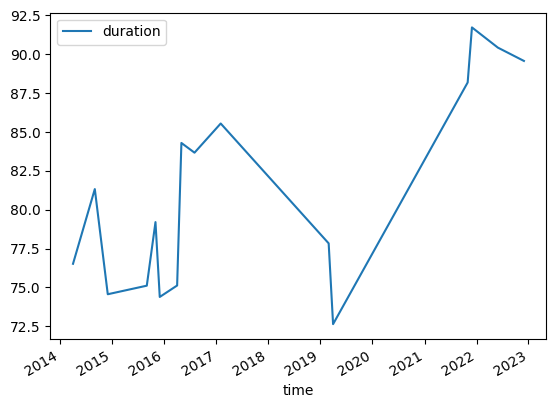

In [57]:
duration_plot = monthly_average[["time", "duration"]].mean().dropna()
duration_plot.plot()


/tmp/ipykernel_31305/683167702.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  survivingp_plot = monthly_average[["time", "survivingCount"]].mean().dropna()


<Axes: xlabel='time'>

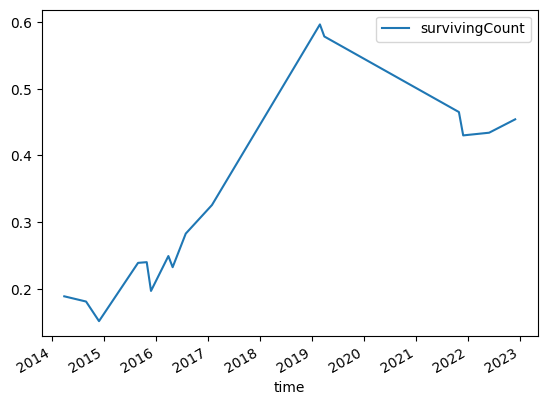

In [58]:
survivingp_plot = monthly_average[["time", "survivingCount"]].mean().dropna()
survivingp_plot.plot()

/tmp/ipykernel_31305/538616652.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  longestkill_plot = monthly_average[["time", "longestKillWaitS"]].mean().dropna()


<Axes: xlabel='time'>

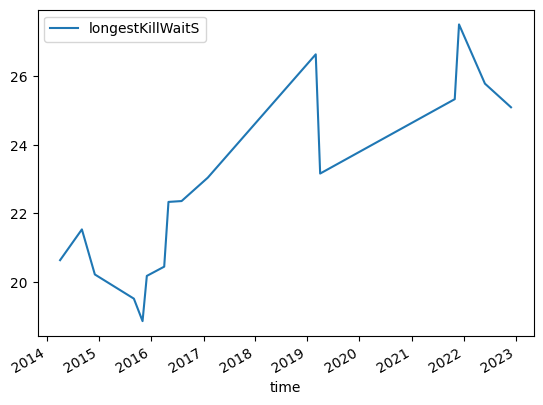

In [59]:
longestkill_plot = monthly_average[["time", "longestKillWaitS"]].mean().dropna()
longestkill_plot.plot()